In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import psutil
from psutil._common import bytes2human
import time
import sys
import numpy as np
import networkx as nx
import torch as tc
import skdim
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn2pmml.util import deep_sizeof
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import scipy.signal as signal
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy as sp
import scipy.fftpack as fftpack
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from matplotlib import rc
%matplotlib inline

from numba import jit
from sklearn.metrics.pairwise import euclidean_distances

# import emlearn
from hummingbird.ml import convert

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Set Directories

In [3]:
base_dir = os.getcwd().replace('\\','/') + '/'
fig_dir = base_dir + 'Figures/Henon Map/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'Henon_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

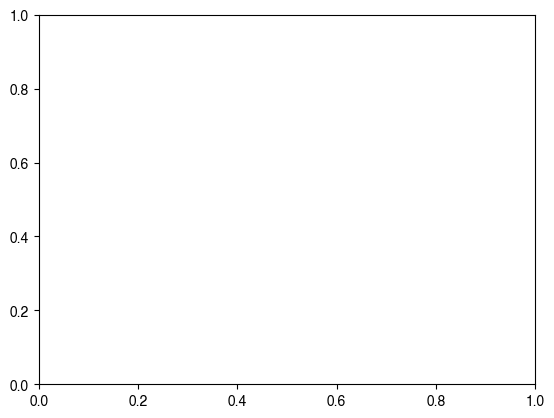

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
# fm.FontProperties(fname='/content/gdrive/MyDrive/Helvetica.ttf', size= 24)
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
# fm.fontManager.addfont(font_dir + 'helvetica.ttf')
# fm.fontManager.ttflist += fm.createFontList(['/content/gdrive/MyDrive/Helvetica.ttf'])
# mpl.rc('font', family='Helvetica')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
# prop = fm.FontProperties(fname=font_dir+'helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [5]:
def henon(x,a=1.4,b=0.3):
    return 1 - a*x[0]**2 + x[1], b*x[0]

def evolve(f,n,x0,a=1.4,b=0.3):
    x = [x0]
    for i in range(1,n):
        x += [f(x[i-1],a,b)]
    return x[-1], np.array(x)

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def get_tau_crits(X_train, p_val=0.05, max_lag=600, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname=''):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else max_lag

    for i in range(N):
        lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
        amis.append(ami)
    amis = np.array(amis).T
    
    for i in range(N):
        amis[:,i] /= amis[0,i]
        
    tau_crits = []
    for i in range(N):
        for j in range(max_lag):
            if amis[j,i] <= p_val:
                break
        tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 10
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1.2]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
            ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.set_xlim(0, max_lag)
            ax.set_ylim(ylim)
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,1,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,1,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            xticks = ax.get_xticks()
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, fontsize=fontsize)
            
            # peaks = signal.argrelextrema(amis[:,i], np.greater)[0]
            # ax.plot(peaks,amis[peaks,i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{:}(\tau)$'.format(dim_labels[i]), fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                   labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                 labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    return Regressor.feature_importances_, end_time-start_time

def future_prediction(features, labels, FIs, future, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='ETR', verbose=False, model_conversion=None,
                      device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])

        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))


    prediction = np.zeros((future,N))
    if s is None:
        s = features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape k*xi
    #     s_delayed = s[:,::xi] # length k
    s_delayed = s[:,-(k-1)*xi-1::xi]

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        #         s_delayed = s[:,::xi]
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        if verbose:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    if verbose:
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
    
    
    if open_loop:
#         prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop).reshape(-1,1)
#         print(s_delayed_open_loop.shape,s_delayed_open_loop[0,:].reshape(1, -1).shape)
#         print(model.predict(s_delayed_open_loop).shape, model.predict(s_delayed_open_loop[0,:].reshape(1, -1))[0].reshape((N,1)).shape)
#         prediction = np.zeros((future,N))
#         for i in range(future):
#             prediction[i,:] = model.predict(s_delayed_open_loop[i,:].reshape(1, -1))[0].reshape((N,1))
    else:
        prediction = np.zeros((future,N))

        # s = y_train[-k*xi-lead+1:len(y_train)-(lead-1)].T.flatten().reshape((N,k*xi))
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        # s_delayed = s[:,-(k-1)*xi-lead::xi]
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            # s_delayed = s[:,-(k-1)*xi-1::xi]
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction)
#     print(prediction.shape)
        
    end_time = time.time()
    if verbose:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_test,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_test[:,i]-y_pred[:,i])**2 for i in range(y_test.shape[1])]), axis=0))

def envelope_length(y_test,y_pred,threshold=5):
    error_signal = rmse_vec(y_test,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def get_left_bin_edge(val,bin_edges):
    for i in range(len(bin_edges)):
        if bin_edges[i] > val:
            break
    return bin_edges[i-1], i-1

def get_bottom_height(current_rects,hist,index,scaling=1):
    bottom = current_rects[index]
    height = 1#/hist[index]
    return bottom*scaling, height*scaling

def add_rect_to_plot(left,bottom,width,height,color,ax=None,alpha=1,zorder=None):
    if zorder is None:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)#,facecolor=color)
    else:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,zorder=zorder,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

def delay_embedding_multidimensional(data, emb_dim, n=None, tau=1):
    # input is shape (n_dims,n_samples)
    data = np.array(data)
    if n is None:
        n = data.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(data)))
    for i in range(n):
        j = i
        embedding[i,:] = data[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def get_correlation_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    dist_mat = euclidean_distances(data, data)
    if lims is None:
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = np.min(dist_mat[np.nonzero(dist_mat)]), np.max(dist_mat)
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
    return _get_correlation_dimension_data(dist_mat, num, lims)

@jit(nopython=True, parallel=True, nogil=True)
def _get_correlation_dimension_data(dist_mat, num, lims):
    n1 = len(dist_mat)
    
    eps_l = np.geomspace(lims[0], lims[1], num=num)
    C_eps_l = np.zeros((num))
    for i, eps in enumerate(eps_l):
        a = np.less(dist_mat, eps)
        np.fill_diagonal(a, 0)
        C_eps_l[i] = np.sum(a)/float(n1**2)
        
    return eps_l, C_eps_l

def correlation_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_slope', param=10, debug_plots=False, debug_data=False):
    eps_l, C_eps_l = get_correlation_dimension_data(data, num, lims, remove_pval)
    eps_l_log = np.log(eps_l)
    C_eps_l_log = np.log(C_eps_l)
    
    if mode == 'highest_slope' or mode == 'highest_r2':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        min_pts = param

        indices = np.arange(len(C_eps_l))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(C_eps_l))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(eps_l_log[window], C_eps_l_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(slopes)
        else:
            i = np.argmax(r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(C_eps_l)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(eps_l_log[start_ind:end_ind],
                        C_eps_l_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(eps_l_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(eps_l_log, C_eps_l_log,'ko',ms=8)

        ax2.plot(eps_l_log[start_ind:end_ind],C_eps_l_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(eps_l_log))
        ax2.plot(eps_l_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(C(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]),
                       poly(np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]-.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        
        
        plt.show()

    if debug_data:
        return coeffs[0], eps_l, C_eps_l
    else:
        return coeffs[0]

# Data

In [6]:
rm_transient = 10

n_train = 100000
n_test = 60000


_, x = evolve(henon,rm_transient + n_train + n_test + 2,(0,0),a=1.4,b=0.3)
X = x
print(x.shape)

X_train, y_train = lead_data(x[rm_transient:rm_transient+n_train+1,:])
X_test, y_test = lead_data(x[rm_transient+n_train+1:,:])
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(160012, 2)
(100000, 2) (60000, 2)
(100000, 2) (60000, 2)


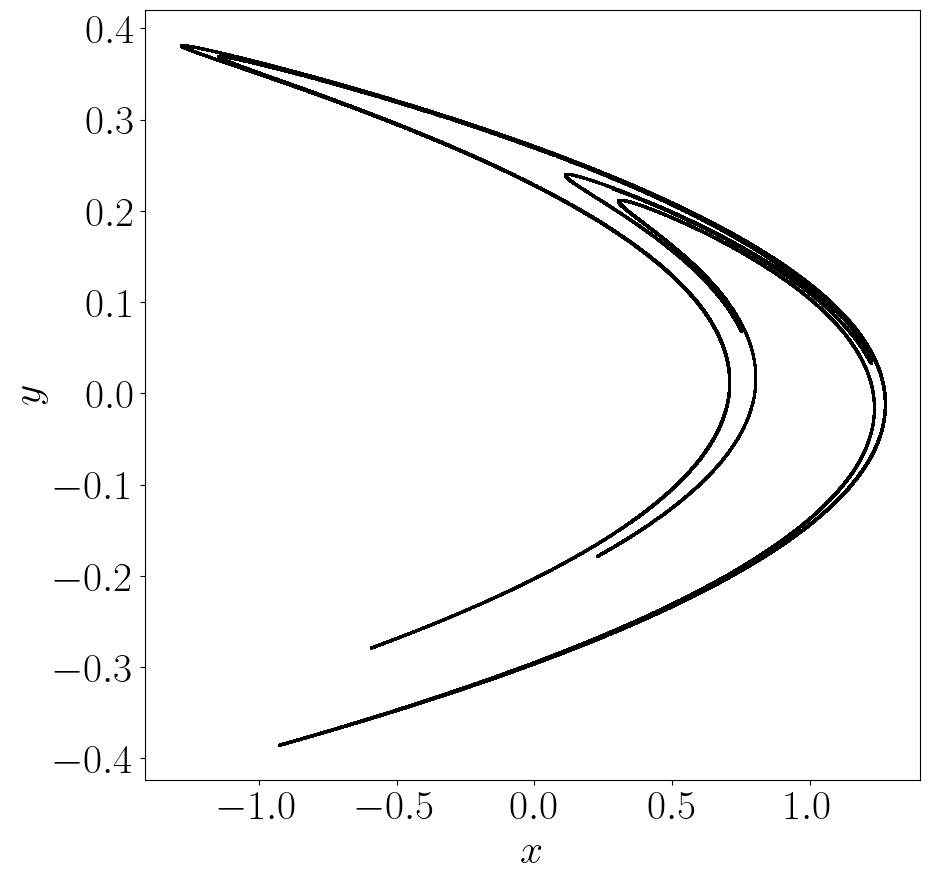

In [7]:
fontsize=30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax1 = plt.subplots(figsize=(10, 10))



ax1.plot(X_train[:,0],X_train[:,1],'ko',ms=1)


plt.xlabel('$x$',fontsize=fontsize, fontproperties=prop)
plt.ylabel('$y$',fontsize=fontsize)
# plt.xlim([2.75,4])
# plt.ylim([0,1])
title = 'Henon Attractor'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=500)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=500)
plt.show()
plt.close(fig)

# TreeDOX

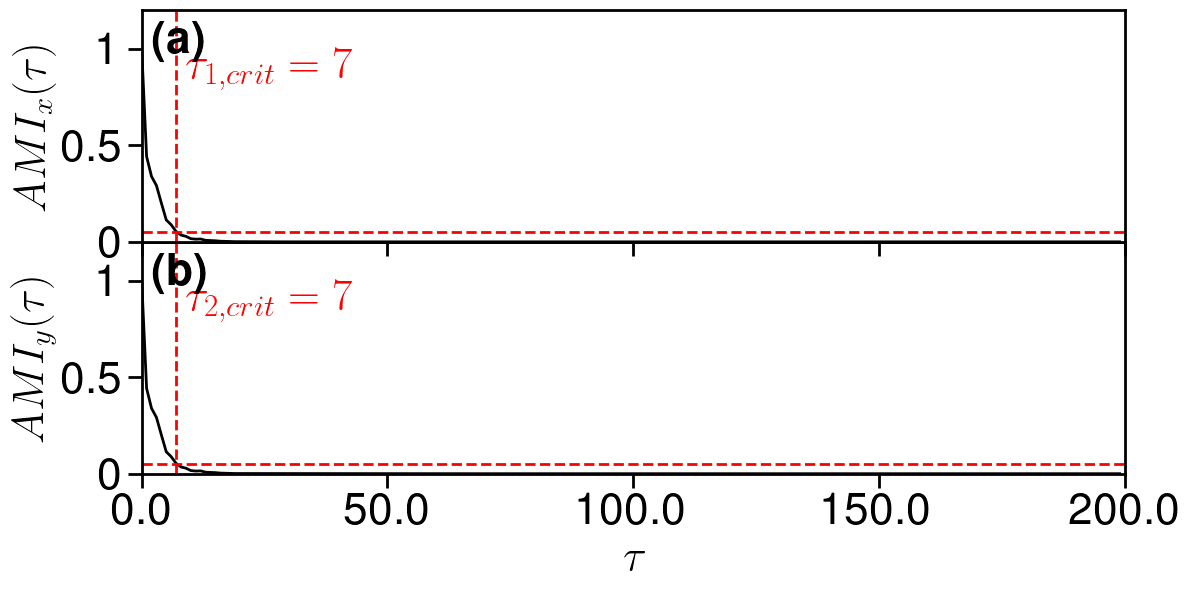

In [8]:
tau_crits = get_tau_crits(X_train, p_val=0.05, max_lag=200, make_plot=True)

In [9]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
print(features.shape, labels.shape)

xi = 1, k = 8
(99992, 16) (99992, 2)


In [25]:
FIs, time_elapsed = feature_selection(features, labels, n_estimators=100, max_depth=None, random_state=None,
                                      n_jobs=-1, n_samples=None, model_type='ETR', verbose=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


Training time: 00 hours, 00 minutes, 06.737504 seconds
RAM Used: 1.5G


In [26]:
s = y_train[-k*xi:len(y_train)].T.flatten()
y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, FIs,
                                                        len(y_test), p=None, xi=xi,
                                                        n_estimators=200,
                                                        disp_progress=True,
                                                        desc='',
                                                        max_depth=None,
                                                        random_state=None,
                                                        n_jobs=-1,
                                                        min_samples_split=2,
                                                        min_samples_leaf=1,
                                                        ccp_alpha=0,
                                                        max_features=0.5,
                                                        n_samples=None,
                                                        model=None, s=s,
                                                        model_type='ETR',
                                                        verbose=False,
                                                        model_conversion=None,
                                                        device='cuda')

Num features selected: 4 of 16
Training time: 00 hours, 00 minutes, 03.311999 seconds
RAM Used: 3.0G


  0%|          | 0/60000 [00:00<?, ?it/s]

Total time: 00 hours, 34 minutes, 21.865095 seconds


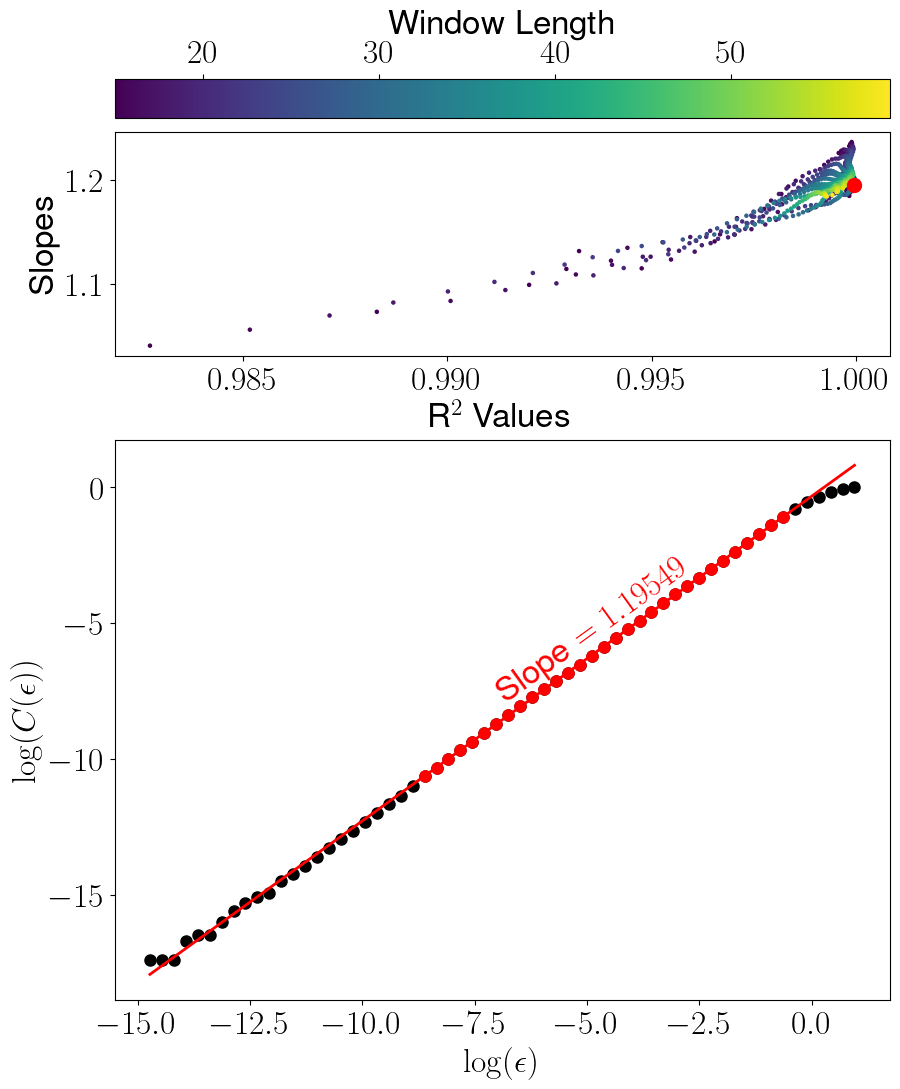

1.1954908561620043


In [27]:
corrdim_test = correlation_dimension(y_test[::5], num=60, lims=None, remove_pval=0.05, 
                                     mode='highest_r2',
                                     param=15, debug_plots=True, debug_data=False)
print(corrdim_test)

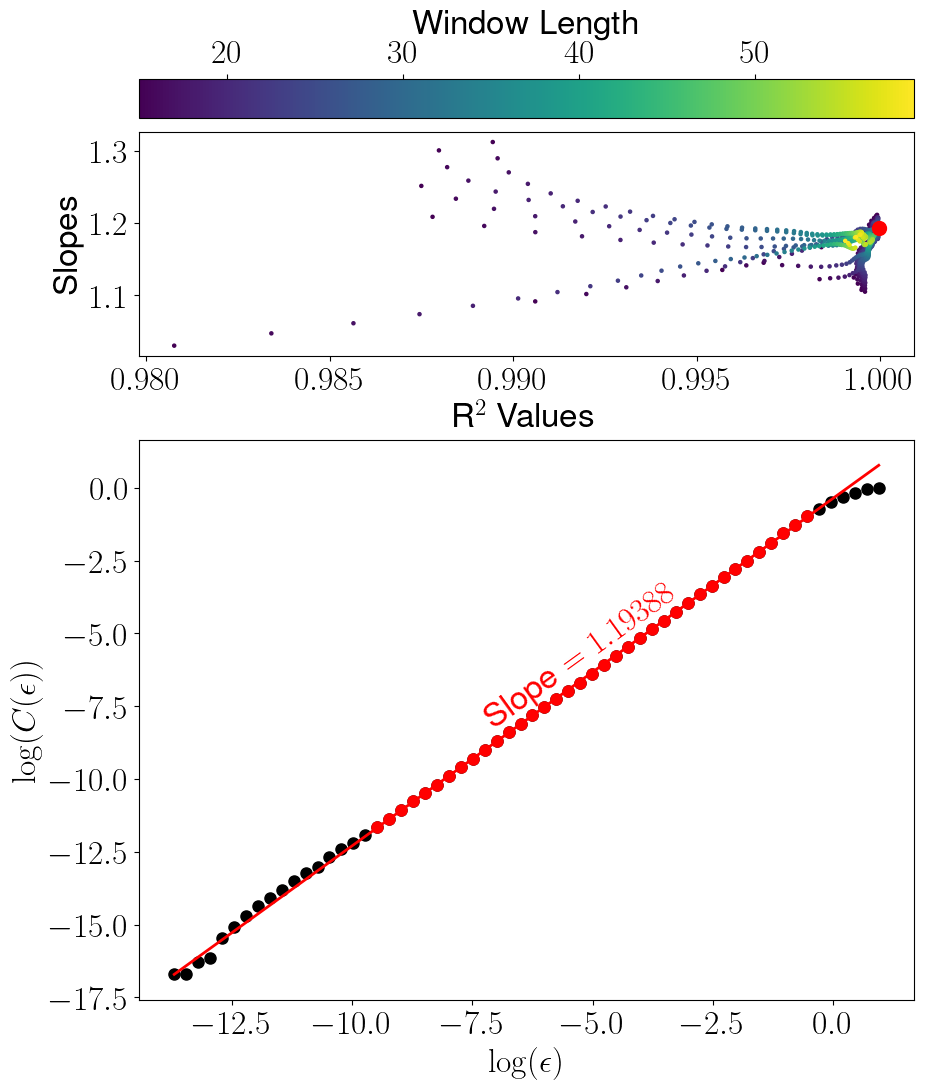

1.1938764325788804


In [28]:
corrdim_pred_TreeDOX = correlation_dimension(y_pred_TreeDOX[::5], num=60, lims=None,
                                             remove_pval=0.05, mode='highest_r2',
                                             param=15, debug_plots=True, debug_data=False)
print(corrdim_pred_TreeDOX)

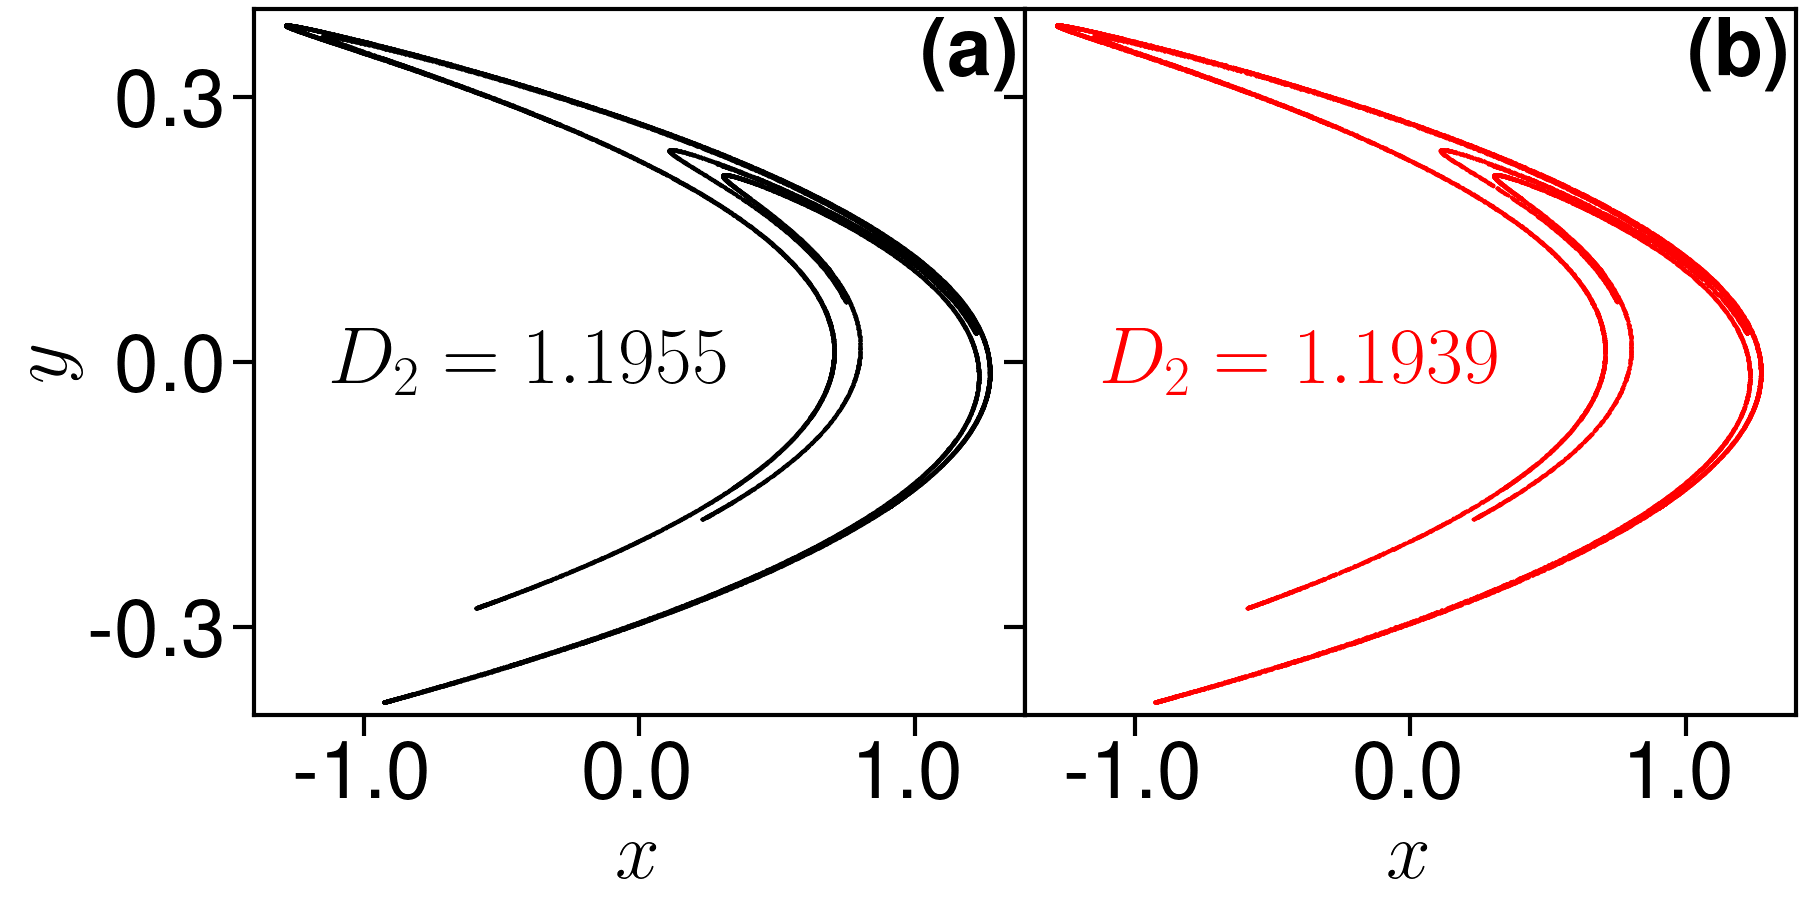

In [29]:
fontsize=58

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(1,2,figsize=(18, 9),sharey=True)
ax1, ax2 = axs


ax1.plot(y_test[:,0],y_test[:,1],'k.',ms=3,label='True', rasterized=True)
ax2.plot(y_pred_TreeDOX[:,0],y_pred_TreeDOX[:,1],'r.',ms=3,label='Predicted', rasterized=True)

ax1.set_xlim([-1.4,1.4])
ax1.set_ylim([-0.4,0.4])
ax2.set_xlim([-1.4,1.4])
ax2.set_ylim([-0.4,0.4])

# xticks = ax1.get_xticks()
# print(xticks)
# xticks = [-1.2,-0.6,0,0.6,1.2]
xticks = [-1, 0, 1]
ax1.set_xticks(xticks)
ax1.set_xticklabels(['{:.1f}'.format(xtick) for xtick in xticks])
ax2.set_xticks(xticks)
ax2.set_xticklabels(['{:.1f}'.format(xtick) for xtick in xticks])
# yticks = ax1.get_yticks()
yticks = [-0.3,0,0.3]
ax1.set_yticks(yticks)
ax1.set_yticklabels(['{:.1f}'.format(ytick) for ytick in yticks])
ax2.set_yticks(yticks)
ax2.set_yticklabels(['{:.1f}'.format(ytick) for ytick in yticks])

ax1.set_xlabel('$x$',fontsize=fontsize, fontproperties=prop)
ax2.set_xlabel('$x$',fontsize=fontsize, fontproperties=prop)
ax1.set_ylabel('$y$',fontsize=fontsize)

handles = [mpl.lines.Line2D([],[],color='k',ls='',marker='.',ms=25,label='True'),
           mpl.lines.Line2D([],[],color='r',ls='',marker='.',ms=25,label='Predicted')]

# ax1.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.025,1.025),prop={'size': fontsize},ncol=3,columnspacing=1,handletextpad=0.5,handlelength=0.5)

ax1.annotate(r'\textbf{(a)}', xy=(0.995,0.99), ha='right', va='top', xycoords="axes fraction", fontsize=fontsize)
ax2.annotate(r'\textbf{(b)}', xy=(0.995,0.99), ha='right', va='top', xycoords="axes fraction", fontsize=fontsize)

ax1.annotate(r'$D_2={:.4f}$'.format(corrdim_test), xy=(0.1,0.5), ha='left', va='center', xycoords='axes fraction', fontsize=fontsize)
ax2.annotate(r'$D_2={:.4f}$'.format(corrdim_pred_TreeDOX), xy=(0.1,0.5), ha='left', va='center', xycoords='axes fraction', fontsize=fontsize, color='r')

plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.0)
fig.align_labels([axs])

ax1.set_zorder(1)
ax2.set_zorder(2)

plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
ax1.tick_params(length=15,width=3)
ax2.tick_params(length=15,width=3)
# ax2.tick_params(length=15,width=3,axis='y',direction='in')

# plt.title('Logistic Map Bifurcation',fontsize=18)
# plt.xlim([2.75,4])
# plt.ylim([0,1])
title = 'Predicted Henon Attractor'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=500)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=500)
plt.show()
plt.close(fig)

# Vary Test Size

In [286]:
test_sizes = (n_test*np.linspace(0,1,201)[1:]).astype(int)
test_sizes = test_sizes[test_sizes >= 500]
print(test_sizes)

[  500   550   600   650   700   750   800   850   900   950  1000  1050  1100  1150  1200  1250  1300  1350  1400  1450  1500  1550  1600  1650  1700  1750  1800  1850  1900  1950  2000  2050  2100  2150  2200  2250  2300  2350  2400  2450  2500
  2550  2600  2650  2700  2750  2800  2850  2900  2950  3000  3050  3100  3150  3200  3250  3300  3350  3400  3450  3500  3550  3600  3650  3700  3750  3800  3850  3900  3950  4000  4050  4100  4150  4200  4250  4300  4350  4400  4450  4500  4550
  4600  4650  4700  4750  4800  4850  4900  4950  5000  5050  5100  5150  5200  5250  5300  5350  5400  5450  5500  5550  5600  5650  5700  5750  5800  5850  5900  5950  6000  6050  6100  6150  6200  6250  6300  6350  6400  6450  6500  6550  6600
  6650  6700  6750  6800  6850  6900  6950  7000  7050  7100  7150  7200  7250  7300  7350  7400  7450  7500  7550  7600  7650  7700  7750  7800  7850  7900  7950  8000  8050  8100  8150  8200  8250  8300  8350  8400  8450  8500  8550  8600  8650
  8700  8750

In [288]:
corrdims_test = []
for test_size in tqdm(test_sizes):
    corrdims_test.append(correlation_dimension(y_test[:test_size], num=40, thresh=0.02, debug_plots=False))
    
corrdims_pred_TreeDOX = []
for test_size in tqdm(test_sizes):
    corrdims_pred_TreeDOX.append(correlation_dimension(y_pred_TreeDOX[:test_size], num=40, thresh=0.02, debug_plots=False))

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

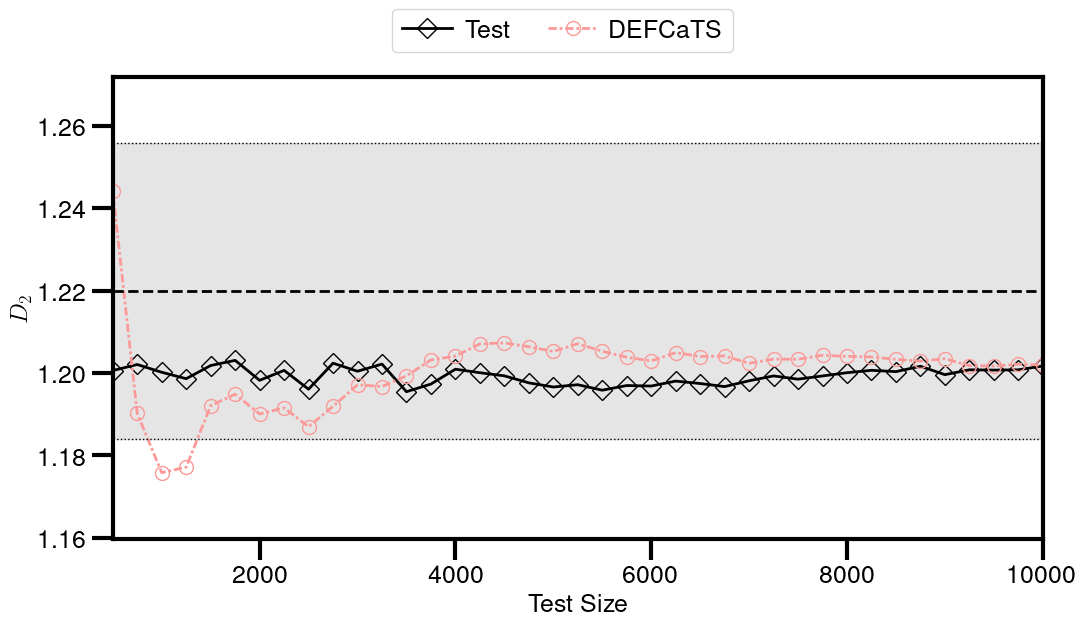

In [319]:
fontsize = 18
legendfontsize = 18

lw = 2
ms = 5
xmin_ind = 0
stride = 5

ylim_stretch = 0.2

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst = [color_lst[4]]

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(test_sizes[::stride], corrdims_test[::stride], 'kD-', lw=lw, ms=10, label='Test', mew=1, mfc='none')
ax.plot(test_sizes[::stride], corrdims_pred_TreeDOX[::stride], 'o', ls=(0, (3, 1, 1, 1)), c=color_lst[0], lw=lw, ms=10, label='TreeDOX', mew=1, mfc='none')

ax.axhline(1.22, c='k', ls='--', lw=lw)
ax.axhline(1.22+0.036, c='k', ls=':', lw=lw/2)
ax.axhline(1.22-0.036, c='k', ls=':', lw=lw/2)
ax.fill_between([test_sizes[0],test_sizes[-1]], 1.22-0.036, 1.22+0.036, color='k', alpha=0.1)
ax.set_xlim(test_sizes[xmin_ind], test_sizes[-1])

ymin = min(1.22-0.036, min(np.min(corrdims_test[xmin_ind:]), np.min(corrdims_pred_TreeDOX[xmin_ind:])))
ymax = max(1.22+0.036, max(np.max(corrdims_test[xmin_ind:]), np.max(corrdims_pred_TreeDOX[xmin_ind:])))
ax.set_ylim(ymin-ylim_stretch*(ymax-ymin), ymax+ylim_stretch*(ymax-ymin))

ax.set_xlabel('Test Size', fontsize=fontsize)
ax.set_ylabel('$D_2$', fontsize=fontsize)

fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
           columnspacing=1.5,handletextpad=0.5)

#     if i_var == 0:
#     ax.set_xlim(0, None)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
#     if i_var == 0:
xticks = ax.get_xticks()[1:]
#     else:
#         yticks = ax.get_yticks()[1:-1]
ax.set_xticks(xticks)
ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)

#     if i_var == 0:
#         ax.set_ylim(0, None)
# ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# ylim = ax.get_ylim()
# ax.set_ylim(ymin-ylim_stretch*(ymax-ymin), ymax+ylim_stretch*(ymax-ymin))
#     if i_var == 0:
yticks = ax.get_yticks()[1:-1]
#     else:
#         yticks = ax.get_yticks()[1:-1]
ax.set_yticks(yticks)
ax.set_yticklabels(f'{ytick:.2f}' for ytick in yticks)



plt.setp(ax.spines.values(), linewidth=3, zorder=100)
ax.tick_params(length=15,width=3)

plt.show()